In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

Using device cuda


In [3]:
mbd = torch.load('data_processed/mbd')

In [11]:
position_ids = torch.arange(1024)[:, None]
d = 512
a = (position_ids/(10000*2*np.pi/2/np.pi)**(torch.arange(d)/d)).sin()

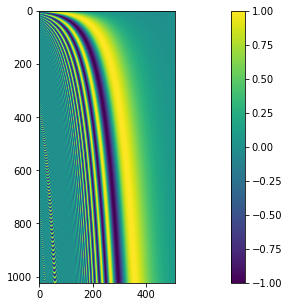

In [13]:
plt.figure(figsize=(20, 5), facecolor='white')
plt.imshow(a.numpy()); plt.colorbar()

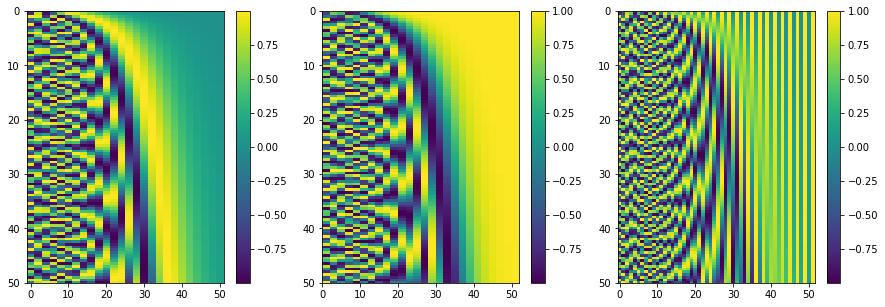

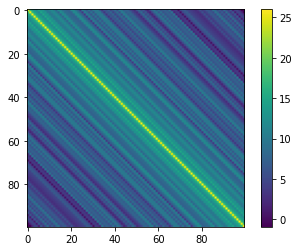

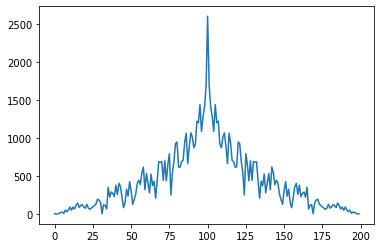

In [5]:
a = util.fourier_pos(0, 50, t=torch.linspace(0, 50, 100), d=52, do_viz=True)
plt.imshow(a@a.T); plt.colorbar()
plt.show()
plt.plot([(a@a.T).diagonal(i).sum().item() for i in range(-100, 100)])
plt.show()

In [4]:
mbd = torch.load('data_processed/mbd')

In [14]:
torch.manual_seed(0)
np.random.seed(0)
batch = next(data.data_loader(batch_size=10240, load_factor=1))

(-60.0, 60.0)

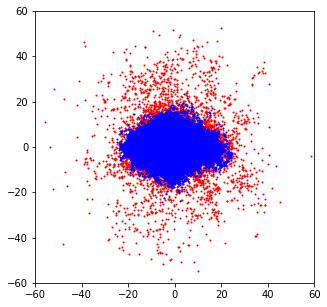

In [15]:
v = batch['nv']
plt.figure(figsize=(5,5))
plt.scatter(*v[:, :1, :2].reshape(-1, 2).numpy().T, s=1., c='r')
plt.scatter(*v[:, 1:, :2].reshape(-1, 2).numpy().T, s=1., c='b')
plt.xlim(-60, 60); plt.ylim(-60, 60)

In [16]:
vx, vy = v[..., 0], v[..., 1]
theta = torch.atan2(vy, vx)
r = v[..., [0, 1]].norm(dim=-1)

In [17]:
dcs = discrete_prob.DiscretizeContinuousSpace(np.full(2, fill_value=-constants.max_speed_ball*.7, dtype=float),
                                              np.full(2, fill_value=+constants.max_speed_ball*.7, dtype=float),
                                              np.full(2, fill_value=21, dtype=int))

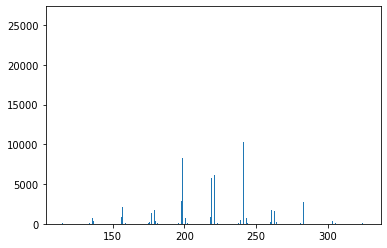

In [18]:
plt.hist(dcs.vec2bin_torch(v[:, 1:, :2].reshape(-1, 2)).numpy(), bins=21*21);

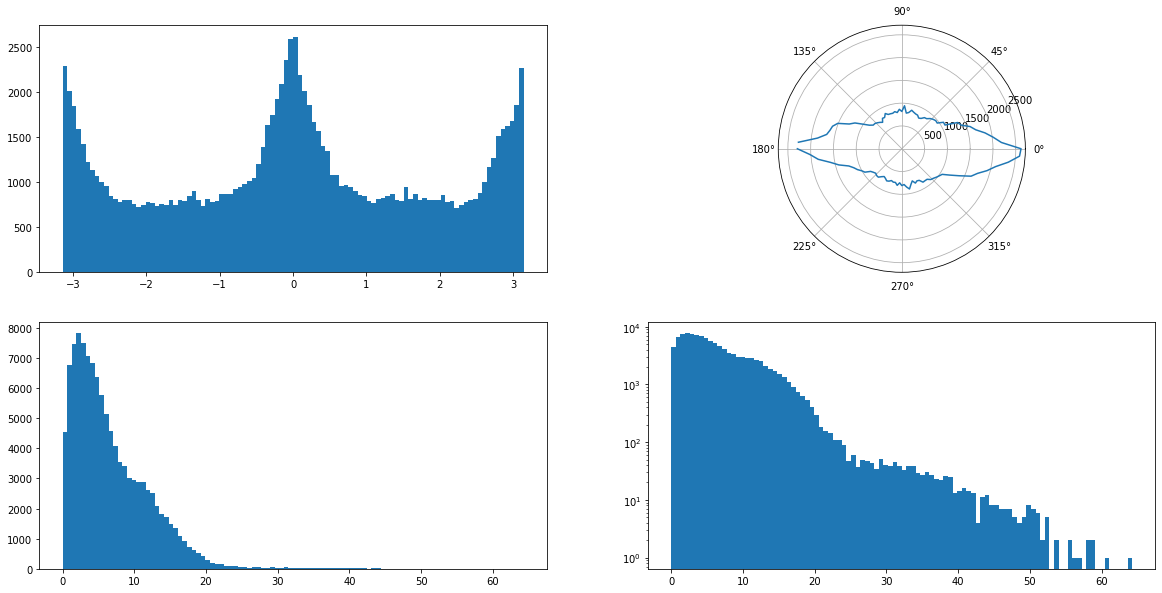

In [54]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.hist(theta.flatten().numpy(), bins=100)
a, b = np.histogram(theta.flatten().numpy(), bins=100)
plt.subplot(222, projection='polar')
plt.plot(b[:100], a)
plt.subplot(223)
plt.hist(r.flatten().numpy(), bins=100)
plt.subplot(224)
plt.hist(r.flatten().numpy(), bins=100)
plt.yscale('log')
plt.show()

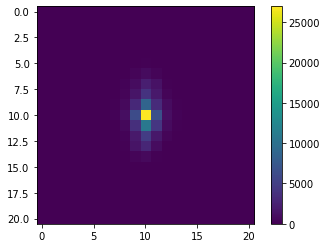

In [55]:
y = dcs.vec2bin_torch(v[..., :2].reshape(-1, 2))
a = np.bincount(y.numpy(), minlength=21*21).reshape(21, 21)
plt.imshow(a)
plt.colorbar()

In [141]:
loss_fn = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.0)
def loss_cross_entropy_balanced(inp, target, minlength=21*21):
    bincount = target.bincount(minlength=minlength)
    loss_fn = nn.CrossEntropyLoss(weight=1./bincount, reduction='mean', label_smoothing=0.0)
    return loss_fn(inp, target).mean()
def loss_cross_entropy_balanced_manual(inp, target, minlength=21*21):
    weight = 1./target.bincount(minlength=minlength)
    loss_fn = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.0)
    return ((weight[target] * loss_fn(inp, target))).sum()/weight[target].sum()
    
torch.manual_seed(0)
a = torch.randn(10240*11, 21*21)
print(loss_cross_entropy_balanced(a[:1000], y[:1000]))
print(loss_cross_entropy_balanced_manual(a[:1000], y[:1000]))

tensor(6.5958)
tensor(6.5958)


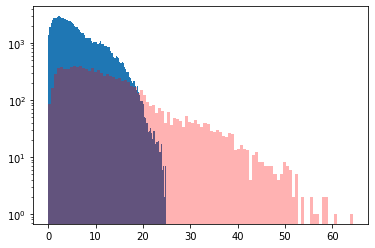

In [151]:
plt.hist(r[:, 1:].flatten().numpy(), bins=100)
plt.hist(r[:, :1].flatten().numpy(), bins=100, color=[1, 0, 0, .3])
plt.yscale('log')
plt.show()

In [154]:
dcs_r = discrete_prob.DiscretizeContinuousSpace(np.full(1, fill_value=0., dtype=float),
                                              np.full(1, fill_value=60., dtype=float),
                                              np.full(1, fill_value=21, dtype=int))
dcs_theta = discrete_prob.DiscretizeContinuousSpace(np.full(1, fill_value=0., dtype=float),
                                              np.full(1, fill_value=60., dtype=float),
                                              np.full(1, fill_value=21, dtype=int))

In [7]:
net = agent.ModelNet(mbd, n_inputs=150, n_outputs=3, embed_dim=200, n_heads=5, mlp_dim=400, n_layers=5).to(device)

In [107]:
for f in os.listdir('data_processed/')[:25]:
    batch = torch.load(f'data_processed/{f}')

(-70.0, 70.0)

ERROR! Session/line number was not unique in database. History logging moved to new session 421


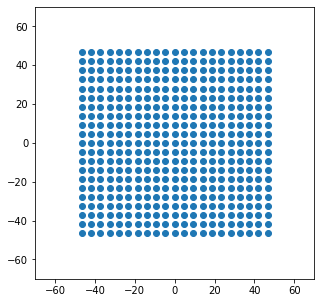

In [42]:
dcs = discrete_prob.DiscretizeContinuousSpace(np.full(2, fill_value=-constants.max_speed_ball*.7, dtype=float),
                                              np.full(2, fill_value=+constants.max_speed_ball*.7, dtype=float),
                                              np.full(2, fill_value=21, dtype=int))
a = dcs.bin2vec(np.arange(np.prod(dcs.n_bins)))
plt.figure(figsize=(5, 5), facecolor='white')
plt.scatter(*a.T)

# for x in np.linspace(-constants.max_speed_ball*.7, constants.max_speed_ball*.7, 21):
#     plt.axhline(x)
#     plt.axvline(x)
plt.xlim(-constants.max_speed_ball, constants.max_speed_ball)
plt.ylim(-constants.max_speed_ball, constants.max_speed_ball)
# plt.gca().hlines(np.linspace(-constants.max_speed_ball, constants.max_speed_human, 21))

In [131]:
# torch.distributions.Categorical(logits=a).entropy().mean()

In [145]:
net = agent.ModelNet(mbd, n_outputs=3, n_embed=210, n_heads=5, mlp_dim=400, n_layers=5)
net(batch['x'], batch['v'], batch['id_team'], batch['id_player']).shape

torch.Size([279, 11, 3])

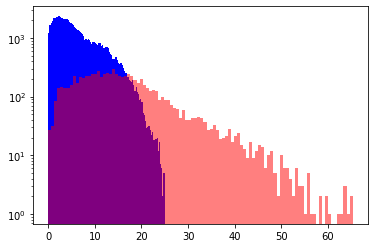

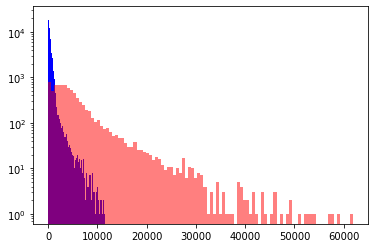

In [88]:
np.random.seed(0); torch.manual_seed(0)
batch = next(data.data_loader(batch_size=8192, load_factor=1, tqdm=None))
plt.hist(batch['v'][..., 1:, :].norm(dim=-1).flatten().numpy(), bins=100, color='b');
plt.hist(batch['v'][..., :1, :].norm(dim=-1).flatten().numpy(), bins=100, color=(1., 0., 0., 0.5));
plt.yscale('log')
plt.show()
plt.hist(batch['a'][..., 1:, :].norm(dim=-1).flatten().numpy(), bins=100, color='b');
plt.hist(batch['a'][..., :1, :].norm(dim=-1).flatten().numpy(), bins=100, color=(1., 0., 0., 0.5));
plt.yscale('log')
# plt.xlim(0, 30000)
plt.show()

In [102]:
bounds = torch.tensor([constants.max_speed_ball] + [constants.max_speed_human]*10)

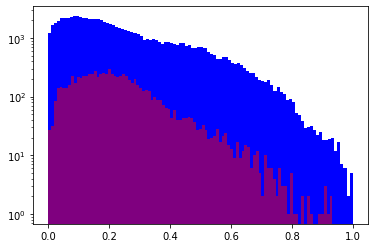

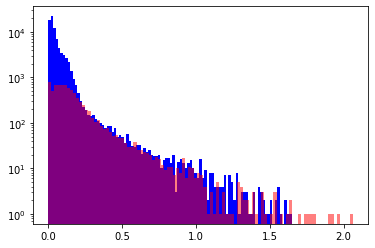

In [109]:
np.random.seed(0); torch.manual_seed(0)
batch = next(data.data_loader(batch_size=8192, load_factor=1, tqdm=None))
bounds = torch.tensor([constants.max_speed_ball] + [constants.max_speed_human]*10)
v = batch['v']/bounds[:, None]
plt.hist(v[..., 1:, :].norm(dim=-1).flatten().numpy(), bins=100, color='b');
plt.hist(v[..., :1, :].norm(dim=-1).flatten().numpy(), bins=100, color=(1., 0., 0., 0.5));
plt.yscale('log')
plt.show()
bounds = torch.tensor([30000] + [7000]*10)
a = batch['a']/bounds[:, None]
plt.hist(a[..., 1:, :].norm(dim=-1).flatten().numpy(), bins=100, color='b');
plt.hist(a[..., :1, :].norm(dim=-1).flatten().numpy(), bins=100, color=(1., 0., 0., 0.5));
plt.yscale('log')
# plt.xlim(0, 30000)
plt.show()

In [ ]:
device='cuda'

In [10]:
seed = 0

use_wandb = True

batch_size = 512
load_factor = 100
np.random.seed(seed); torch.manual_seed(seed)

dcs = None
dcs = discrete_prob.DiscretizeContinuousSpace(np.full(3, fill_value=-1, dtype=float),
                                              np.full(3, fill_value=+1, dtype=float),
                                              [21, 21, 1])
predict_acceleration = True
if predict_acceleration:
    bounds = torch.tensor([30000] + [7000]*10)[:, None]
else:
    bounds = torch.tensor([constants.max_speed_ball] + [constants.max_speed_human]*10)[:, None]

n_bins_total = None if dcs is None else np.prod(dcs.n_bins)
bin_count = torch.zeros(n_bins_total).to(device)

# net = agent.ModelNet(mbd, n_outputs=(3 if dcs is None else n_bins_total),
#                      n_embed=210, n_heads=5, mlp_dim=400, n_layers=5).to(device)
net = agent.ModelNet(mbd, n_outputs=(3 if dcs is None else n_bins_total),
                     n_embed=750, n_heads=10, mlp_dim=1000, n_layers=8).to(device)
loss_cross_entropy = nn.CrossEntropyLoss()

print('# of Model Parameters: ', np.sum([p.numel() for p in net.parameters()]))
# for p in net.parameters():
    # p.data.uniform_(-1e-3, 1e-3)

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

if use_wandb: wandb.init()

losses = []
pbar = tqdm(range(50))
for idx_epoch in pbar:
    for idx_batch, batch in enumerate(data.data_loader(batch_size=batch_size, load_factor=load_factor, tqdm=tqdm)):
        
        x = batch['x'].float().to(device)
        v = batch['v'].float().to(device)
        id_team = batch['id_team'].to(device)
        id_player = batch['id_player'].to(device)
        
        y_batch_pred = net.forward(x, v=v, id_team=id_team, id_player=id_player)
        
        if dcs is None:
            y = batch['nv'].to(device)
            loss = (y_batch_pred-y).pow(2.).mean()
        else:
            current = batch['a' if predict_acceleration else 'v']
            nextt = batch['na' if predict_acceleration else 'nv']
            py = dcs.vec2bin_torch(current/bounds).to(device)
            y = dcs.vec2bin_torch(nextt/bounds).to(device)
            
            bin_count[y.reshape(-1)] = bin_count[y.reshape(-1)] + 1
            
            loss = loss_cross_entropy(y_batch_pred.reshape(-1, n_bins_total), y.reshape(-1))
            ploss = loss_cross_entropy(y_batch_pred.reshape(-1, n_bins_total), py.reshape(-1))
            
            categorical = torch.distributions.Categorical(logits=y_batch_pred)
            entropy = categorical.entropy().detach().cpu().flatten().numpy()
            
            if use_wandb: wandb.log({'entropy': wandb.Histogram(entropy)}, commit=False)
            if use_wandb: wandb.log({'ploss': ploss.item()}, commit=False)
            
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses.append(loss.item())

        pbar.set_postfix({'loss': loss.item()})
        
        if use_wandb: wandb.log({'loss': loss.item()})


# of Model Parameters:  31320941


loss,▇█▃▂▂▂▂▃▂▂▃▁▂▂▂▂▂▃▁▂▂▂▂▂▁▂▂▂▃▂▁▂▂▁▁▁▂▂▂▂
ploss,▇█▃▃▂▂▂▂▂▂▃▂▂▂▂▁▂▂▁▃▂▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁▁▃▂▂
loss,1.68273
ploss,1.57295


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/202504 [00:00<?, ?it/s]

KeyboardInterrupt: 

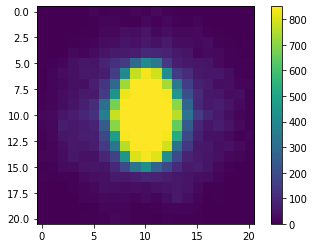

In [ ]:
plt.imshow(bin_count.reshape(21, 21).detach().cpu().numpy())
plt.colorbar()

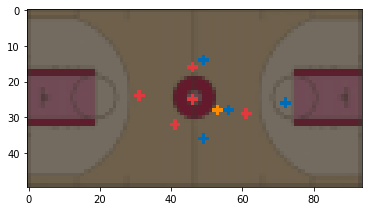

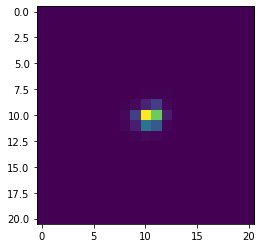

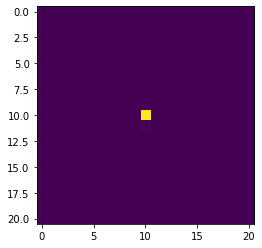

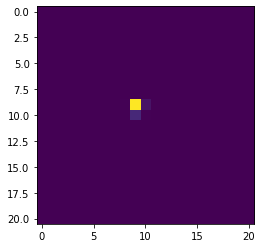

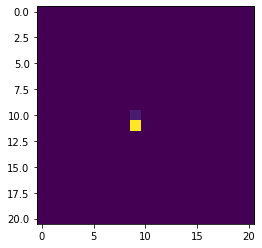

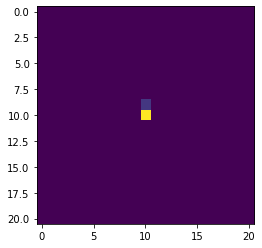

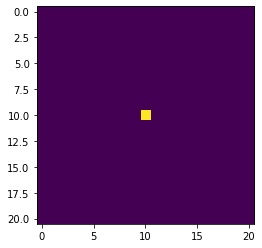

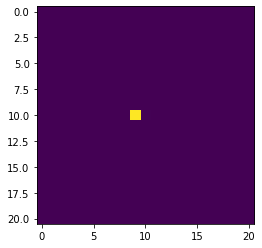

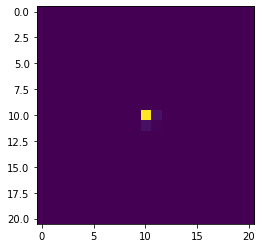

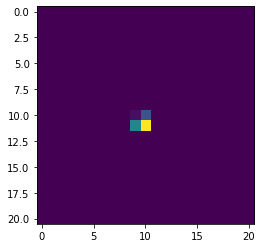

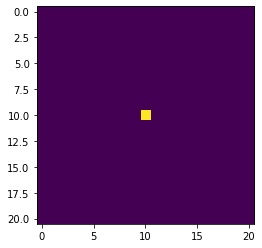

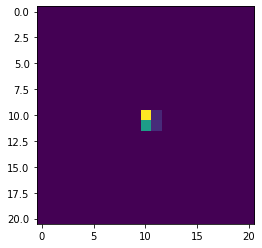

In [31]:
batch = torch.load('data_processed/0021500001_00000.pth')
batch = torch_dict.to(torch_dict.index(batch, [0]), device)
x = batch['x']
v = batch['v']
id_team = batch['id_team']
id_player = batch['id_player']

output = net.forward(x, v, id_team, id_player)

vid = animation.create_video(mbd, x, id_team, id_player)
plt.imshow(vid[0].permute(1, 2, 0).numpy())
plt.show()

for i in range(11):
    plt.imshow(output[0, i].softmax(dim=-1).reshape(21, 21).detach().cpu().numpy())
    plt.show()

In [8]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

for f in tqdm([f'data_processed/{f}' for f in os.listdir('data_processed/')[:25]]):
    batch = torch.load(f)
    x = batch['x'].to(device)
    v = batch['v'].to(device)
    id_team = batch['id_team'].to(device)
    id_player = batch['id_player'].to(device)
    # print(x.shape, v.shape, id_team.shape, id_player.shape)
    
    xs = []
    xi, vi = x[:1], v[:1]
    for i in range(len(x)):
        xs.append(xi.detach().cpu().clone())
        output = net.forward(xi, v=vi, id_team=id_team[:1], id_player=id_player[:1])
        if dcs is None:
            pass
        else:
            categorical = torch.distributions.Categorical(logits=output)
            vi = dcs.bin2vec_torch(categorical.sample().detach().cpu()).to(device).float()
        xi = xi + vi*0.04
        xi[..., 0] = xi[..., 0].clip(0,94)
        xi[..., 1] = xi[..., 1].clip(0,50)
    xs = torch.cat(xs, dim=0)
    
    vid_true = animation.create_video(mbd, x, id_team=id_team, id_player=id_player)
    vid_pred = animation.create_video(mbd, xs, id_team=id_team, id_player=id_player)
    vids = animation.stitch_videos([vid_true, vid_pred], (1, 2))
    wandb.log({'vids_clipped': wandb.Video(vids, fps=25)})
    # print(vids.shape)
    # plt.imshow(vid_true[-1].permute(1, 2, 0).numpy())
    # plt.show()
    # plt.imshow(vid_pred[-1].permute(1, 2, 0).numpy())
    # plt.show()
    
    # break
    


Error in callback <function _WandbInit._resume_backend at 0x2b6a9ed0f700> (for pre_run_cell):


Exception: The wandb backend process has shutdown

  0%|          | 0/25 [00:00<?, ?it/s]

Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x2b6a9ed0f8b0> (for post_run_cell):


Exception: The wandb backend process has shutdown

Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 167, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/interface/interface.py", line 114, in communicate_stop_status
    resp = self._communicate_stop_status(status)
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/wandb/sdk/interface/interface_shared.py", line 387, in _communicate_stop_status
    resp = self._communicate(req, local=True)
  File "/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-pa

            Model loss: 2.23295080858469
Previous velocity loss: 4.676649570465088


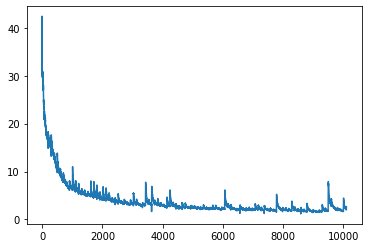

In [79]:
plt.plot(losses)

loss_pv = (batch['v']-batch['nv']).pow(2.).mean()
print(f'            Model loss: {np.mean(losses[-4000:])}')
print(f'Previous velocity loss: {loss_pv}')

In [115]:
np.random.seed(1)
torch.manual_seed(1)

batch = next(data.data_loader(batch_size=1, load_factor=1))
x = batch['x'].to(device)[:1]
id_team = batch['id_team'].to(device)[:1]
id_player = batch['id_player'].to(device)[:1]

xs = []
for i in tqdm(range(400)):
    xs.append(x.detach().cpu().clone())
    nv = net.forward(x, id_team=id_team, id_player=id_player)
    x = x+nv*0.04

x = torch.cat(xs, dim=0)
id_team = id_team.repeat(len(x), 1)
id_player = id_player.repeat(len(x), 1)
print(x.shape, id_team.shape, id_player.shape)

  0%|          | 0/400 [00:00<?, ?it/s]

torch.Size([400, 11, 3]) torch.Size([400, 11]) torch.Size([400, 11])


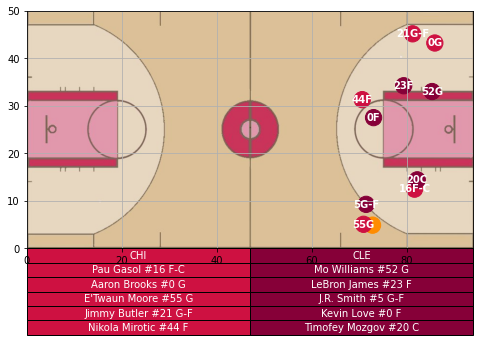

In [116]:
ba = animation.BasketballAnimation(mbd, x, id_team, id_player, None)

In [118]:
! rm vid.gif
ba.anim.save('vid.gif')

In [ ]:
import torch


In [ ]:
for seed in tqdm(range(100)):
    np.random.seed(seed)
    torch.manual_seed(seed)

    batch = next(data.data_loader(batch_size=1, load_factor=1))
    x = batch['x'].to(device)[:1]
    id_team = batch['id_team'].to(device)[:1]
    id_player = batch['id_player'].to(device)[:1]

    xs = []
    for i in tqdm(range(400)):
        xs.append(x.detach().cpu().clone())
        nv = net.forward(x, id_team=id_team, id_player=id_player)
        x = x+nv*0.04

    x = torch.cat(xs, dim=0)
    id_team = id_team.repeat(len(x), 1)
    id_player = id_player.repeat(len(x), 1)
    ba = animation.BasketballAnimation(mbd, x, id_team, id_player, None)
    ba.anim.save(f'out/{seed}.gif')
    plt.close('all')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

In [7]:

batch = next(data.data_loader(batch_size=100000, load_factor=1))

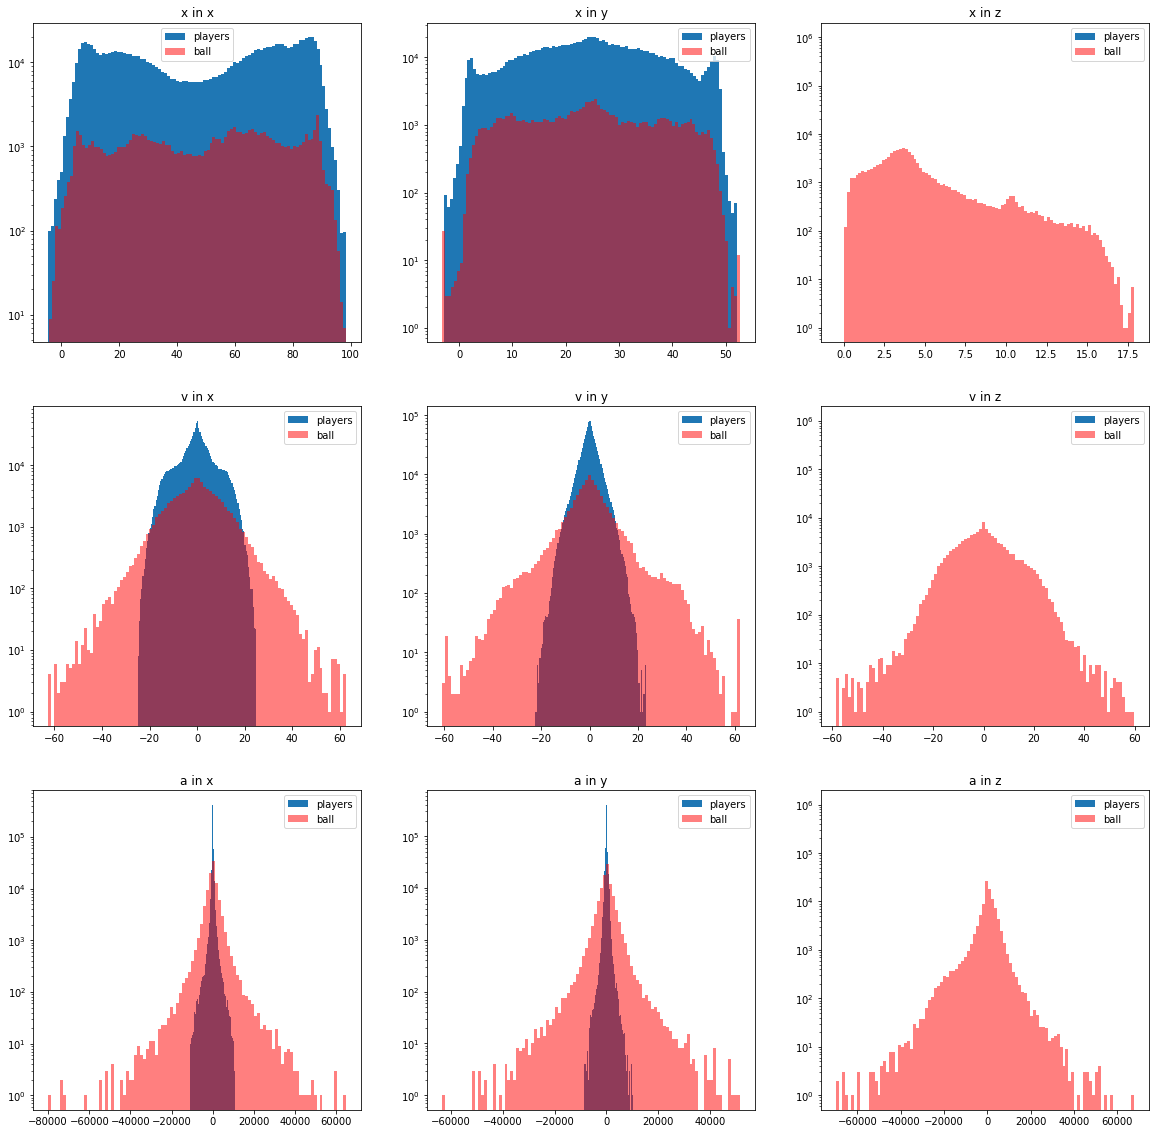

In [13]:
plt.figure(figsize=(20, 20))
for i, key in enumerate(['x', 'v', 'a']):
    for j, direction in enumerate(['x', 'y', 'z']):
        plt.subplot(3, 3, i*3+j+1)
        plt.title(f'{key} in {direction}')
        plt.hist(batch[f'{key}'][..., 1:, j].flatten().numpy(), bins=100, label='players');
        plt.hist(batch[f'{key}'][..., :1, j].flatten().numpy(), bins=100, color=[1,0,0,.5], label='ball');
        plt.yscale('log')
        plt.legend()
    
# plt.subplot(1, 4, 4)
# plt.hist(ds.ds['v'][..., 1:, :].norm(dim=-1).flatten().numpy(), bins=100);
# plt.hist(ds.ds['v'][..., :1, :].norm(dim=-1).flatten().numpy(), bins=100, color=[1,0,0,.5]);
# plt.yscale('log')
plt.show()

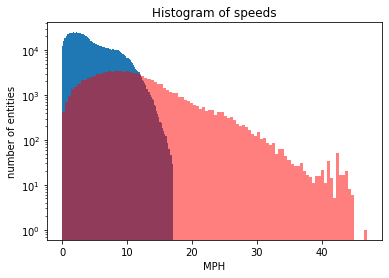

In [14]:
speed = (batch['v'].norm(dim=-1))
plt.title('Histogram of speeds')
plt.xlabel('MPH'); plt.ylabel('number of entities')
plt.hist(speed[:, 1:].flatten().numpy()/1.467, bins=100, label='Players');
plt.hist(speed[:, 0].flatten().numpy()/1.467, bins=100, color=[1,0,0,.5], label='Ball');
plt.yscale('log')

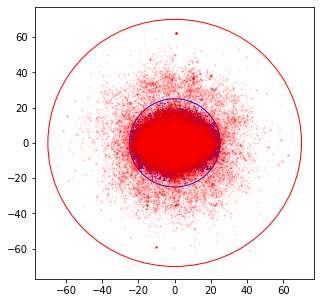

In [16]:
from constants import max_speed_ball, max_speed_human
v = batch['v']

plt.figure(figsize=(5,5))
plt.scatter(v[:, 1:, 0].flatten().numpy(), v[:, 1:, 1].flatten().numpy(), s=.1, color=[0., 0., 1., 1.])
plt.gca().add_patch(plt.Circle((0, 0), max_speed_human, color='b', fill=False))

plt.scatter(v[:, 0, 0].flatten().numpy(), v[:, 0, 1].flatten().numpy(), s=1, color=[1., 0, 0, .1])
plt.gca().add_patch(plt.Circle((0, 0), max_speed_ball, color='r', fill=False))

plt.show()


In [64]:
from discrete_prob import DiscretizeContinuousSpace
n_bins = np.ones(2, dtype=int)*2
dcs = DiscretizeContinuousSpace(np.zeros(2)-1.5, np.zeros(2)+1.5, n_bins)


[-1.5 -1.5] [1.5 1.5] [2 2]


In [494]:
v = ds.ds['nv']

In [495]:
# v.min(dim=-2).values.min(dim=-2).values, v.max(dim=-2).values.max(dim=-2).values
v.mean(dim=(-2, -3)), v.std(dim=(-2, -3))*3, 

(tensor([-0.0462, -0.0166, -0.0024], dtype=torch.float64),
 tensor([22.3087, 13.4190,  8.4228], dtype=torch.float64))

In [496]:
dcs.vec2bin(v[..., :2].numpy())

array([[1, 3, 3, ..., 1, 1, 2],
       [1, 3, 3, ..., 1, 3, 2],
       [0, 3, 3, ..., 1, 3, 2],
       ...,
       [3, 1, 2, ..., 3, 3, 0],
       [1, 1, 2, ..., 3, 3, 0],
       [2, 1, 2, ..., 3, 3, 0]])

  0%|          | 0/1000 [00:00<?, ?it/s]

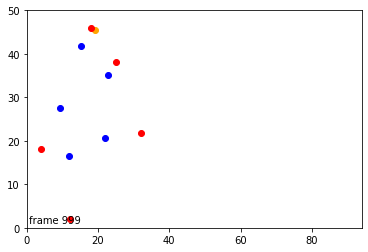

In [667]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)
for frame_idx in tqdm(range(1000)):
    plt.text(0.5, 1.01, f'frame {frame_idx}')#, transform=ax.transAxes)
    plt.scatter(*ds.ds['x'][frame_idx, :1][:, :2].numpy().T, c='orange')
    plt.scatter(*ds.ds['x'][frame_idx, 1:6][:, :2].numpy().T, c='b')
    plt.scatter(*ds.ds['x'][frame_idx, 6:][:, :2].numpy().T, c='r')
    plt.xlim(0, 94)
    plt.ylim(0, 50)
    camera.snap()

animation = camera.animate(interval=40)
# plt.close(fig)
# HTML(animation.to_html5_video())
animation.save('animation.mp4')

# things to track for this experiment:
- ball x, ball y
- p1 x, p1 y, p1 vx, p1 vy, p1 ax, p1 ay
- ...


# outputs
- movements


In [319]:
from net import ModelNet

In [320]:
    
net = ModelNet(game)
# net(x_batch).shape

In [67]:
from discrete_prob import DiscretizeContinuousSpace
n_bins = np.ones(2, dtype=int)*2
dcs = DiscretizeContinuousSpace(np.zeros(2)-1.5, np.zeros(2)+1.5, n_bins)

[-1.5 -1.5] [1.5 1.5] [2 2]


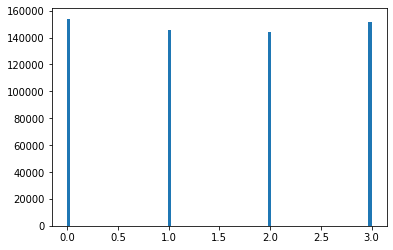

In [68]:
a = ds.ds['x']
x_mean, x_std = a.mean(dim=(-2, -3)), a.std(dim=(-2, -3))
batch_y = torch.from_numpy(dcs.vec2bin(ds.ds['nv'][..., :2].numpy()))
plt.hist(batch_y.flatten().numpy(), bins=100);

In [69]:
ds.ds['x'].shape

torch.Size([54136, 11, 3])

In [70]:
ds.ds['x'].numel()*4*10/1e9

0.07145952

In [321]:
from dataset import index_data_dict

In [323]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

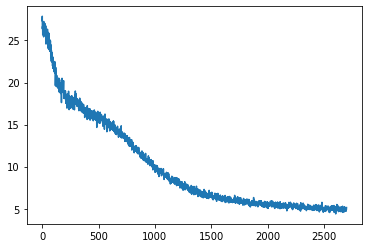

In [333]:
plt.plot(losses)

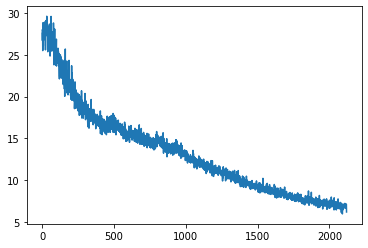

In [79]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team, embedded id_player

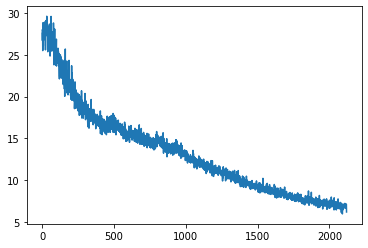

In [79]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team, embedded id_player

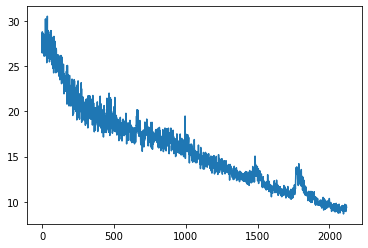

In [53]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team

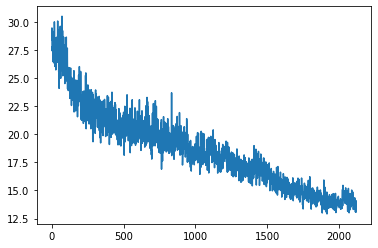

In [616]:
plt.plot(losses) #for the mse loss with xyz inputs

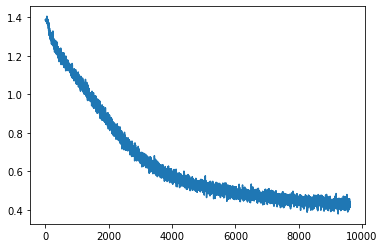

In [612]:
plt.plot(losses) #for the crossentropy 4-quadrant classification loss with xyz inputs

In [535]:
v = ds.ds['v']
nv = ds.ds['nv']
a = dcs.vec2bin(v[..., :2].numpy())
b = dcs.vec2bin(nv[..., :2].numpy())

In [118]:
batch = index_data_dict(ds.ds, 0)
x = batch['x'][None].float()
id_team = batch['id_team'][None]
id_player = batch['id_p'][None]
xs = []

for i in tqdm(range(100)):
    xs.append(x.detach().cpu().clone())
    nv = net.forward(x, id_team, id_player)
    x = x+nv*0.04

xs = torch.stack(xs)[:, 0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [121]:
x.shape

torch.Size([11, 3])

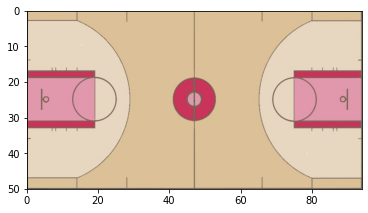

In [181]:
from Constant import Constant

court = plt.imread("court.png")
plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                    Constant.Y_MAX, Constant.Y_MIN])

In [182]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)
for i in tqdm(range(0, 100, 1)):
    x = xs[i]
    plt.text(0.5, 1.01, f'frame {i}')#, transform=ax.transAxes)
    plt.scatter(*x[:1, :2].numpy().T, c='orange')
    plt.scatter(*x[1:6, :2].numpy().T, c='b')
    plt.scatter(*x[6:, :2].numpy().T, c='r')
    plt.xlim(0, 94)
    plt.ylim(0, 50)
    
    plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                        Constant.Y_MAX, Constant.Y_MIN])
    camera.snap()

animation = camera.animate(interval=40)
plt.close(fig)
HTML(animation.to_html5_video())
# animation.save('animation.mp4')

  0%|          | 0/100 [00:00<?, ?it/s]